# Water Closure Levels

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)

In [4]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the CAMELS data

In [6]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

In [7]:
bool_wb = xr.open_dataset(data_dir / "RUNOFF/bool_water_balance_20pct.nc")
bool_wb = bool_wb.to_array().isel(variable=0).drop("variable")
bool_wb

<xarray.DataArray (station_id: 671)>
array([False,  True, False, False,  True,  True, False, False, False,
        True, False, False, False,  True,  True, False,  True, False,
        True,  True,  True, False,  True,  True, False,  True, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
       False, False,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True, False,  True,  True, False, False,
       False, False, False, False, False, False,  True,  True,  True,
       False,  True,  True,  True, False, False,  True, False,  True,
        True, False, False, False, False, False,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False, False,  True, False,  True,  True,
        True, False, False,  True,  True,  True, False, False, False,
       False,  True,  True,  True,  True, False, False,  True,  True,
       False,  True, False,  True,  True, False, False,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False,  True,  True,  True, False,
       False, False, False, False,  True,  True,  True,  True, False,
       False,  True, False,  True,  True,  True, False,  True,  True,
        True,  True, False,  True, False,  True,  True,  True, False,
       False, False,  True,  True, False,  True, False, False,  True,
        True, False, False,  True,  True,  True, False,  True,  True,
        True, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False,  True,  True,  True, False, False, False, False,  True,
       False, False,  True, False,  True,  True, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True, False,
        True, False,  True, False,  True, False,  True,  True,  True,
        True, False, False,  True, False,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True, False, False,  True, False, False, False, False,  True,
       False, False,  True, False, False, False, False,  True, False,
       False, False,  True,  True,  True, False,  True, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True, False, False, False,  True, False,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True, False,  True,  True, False, False,  True, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True, False, False, False,  True,
       False,  True,  True,  True, False,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  

# Read in AWS Models

In [8]:
# ealstm_less_vars = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
# ealstm_preds = xr.open_dataset(data_dir / "runs/ensemble/data_ENS.csv")
ealstm_ensemble_df = pd.read_csv(data_dir / "runs/ensemble_EALSTM/data_ENS.csv").drop("Unnamed: 0", axis=1)
ealstm_ensemble_df["time"] = pd.to_datetime(ealstm_ensemble_df["time"])
ealstm_preds = ealstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()

ealstm_preds["station_id"] = [int(sid) for sid in ealstm_preds["station_id"]]

In [9]:
lstm_ensemble_df = pd.read_csv("/cats/datastore/data/runs/ensemble_pet/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df = pd.read_csv("/cats/datastore/data/runs/ensemble_pet_trainperiod/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df["time"] = pd.to_datetime(lstm_ensemble_df["time"])
lstm_ensemble = lstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()
lstm_preds = lstm_ensemble

# Fuse Data

In [10]:
all_paths = [d for d in (data_dir / "RUNOFF/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "RUNOFF/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "RUNOFF/ALL_fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")

In [11]:
fuse_ds = fuse_ds.sel(time=slice('1998-01-01', '2009-01-01'))

In [12]:
# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["discharge_spec"]
).rename("obs")
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)

# Match Station / Times

In [13]:
all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)
all_stations_ealstm = np.isin(ealstm_preds.station_id, fuse_data.station_id)

lstm_preds = lstm_preds.sel(station_id=all_stations_lstm, time=fuse_data.time)
ealstm_preds = ealstm_preds.sel(station_id=all_stations_ealstm, time=fuse_data.time)

# Errors

In [14]:
from scripts.drafts.calculate_error_scores import calculate_all_data_errors, get_metric_dataframes_from_output_dict
from scripts.drafts.calculate_error_scores import DeltaError

# calculate all error metrics
processor = DeltaError(ealstm_preds, lstm_preds, fuse_data)
all_preds = processor.all_preds

if "all_errors" not in globals().keys():
    all_errors = calculate_all_data_errors(all_preds)
all_metrics = get_metric_dataframes_from_output_dict(all_errors)
all_metrics.keys()

Errors: 100%|██████████| 6/6 [01:12<00:00, 12.01s/it]


dict_keys(['nse', 'kge', 'mse', 'bias', 'log_nse', 'inv_kge', 'abs_pct_bias', 'mape', 'mam30_ape', 'rmse'])

# Calculate Water Balances

In [15]:
def assign_wateryear(dt):
    """https://stackoverflow.com/a/52615358/9940782"""
    dt = pd.Timestamp(dt)
    if dt.month >= 10:
        return(pd.datetime(dt.year+1,1,1).year)
    else:
        return(pd.datetime(dt.year,1,1).year)

In [16]:
ds_wy = ds.assign_coords(wy=("time", [assign_wateryear(dt) for dt in ds.time.values]))
# lstm_preds_wy = lstm_preds.assign_coords(wy=("time", [assign_wateryear(dt) for dt in lstm_preds.time.values]))

In [17]:
from typing import List, Tuple, Optional


def create_closure_masks(
    ds: xr.Dataset,
    closure_thresholds: List[float] = [0.05, 0.1, 0.15, 0.2, 0.25],
    method: str = "sum",
) -> Tuple[xr.Dataset]:
    assert all([(c <= 1) & (c > 0) for c in closure_thresholds]), "Need to be between 0 and 1 (ratio)"
    # assign water year as a coordinate
    ds_wy = ds.assign_coords(wy=("time", [assign_wateryear(dt) for dt in ds.time.values]))
    
    # calculate water balance and mean precip
    if method == "sum":
        ann_aggregated = ds_wy.groupby("wy").sum().isel(wy=slice(1, -1))
    elif method == "mean":
        ann_aggregated = ds_wy.groupby("wy").mean().isel(wy=slice(1, -1))
    else: 
        assert False, "One of [sum, mean] required for calculating WaterYear WB"
    
    ann_closure = ann_aggregated["precipitation"] - ann_aggregated["pet"] - ann_aggregated["discharge_spec"]
    mean_closure = ann_closure.mean('wy')
    mean_precip = ann_aggregated["precipitation"].mean("wy")

    # calculate outside the error
    masks = []
    for c in closure_thresholds:
        # calculate the % of the precip marking the 'error'
        thresh = mean_precip * c
        ref_value_upper = 0.5 * thresh
        ref_value_lower = -0.5 * thresh

        bool_wb = ((ref_value_lower < mean_closure) & (ref_value_upper > mean_closure))
        bool_wb = bool_wb.to_dataset(**dict(name="mask")).assign_coords(threshold=c).expand_dims(dim="threshold")
        masks.append(bool_wb)
        
    threshold = xr.concat(masks, dim='threshold')
    
    return threshold, (mean_closure, mean_precip)

In [18]:
thresholds, (mean_closure, mean_precip) = create_closure_masks(ds, method="sum", closure_thresholds=[0.05, 0.1, 0.15, 0.2, 0.25, 1.0])
thresholds = thresholds.sel(station_id=all_preds.station_id.values)

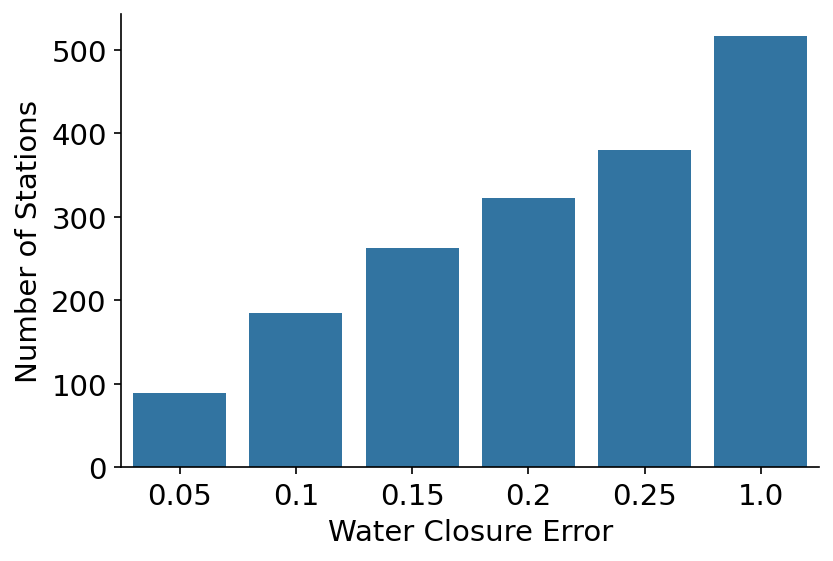

In [19]:
f, ax = plt.subplots()
sns.barplot(x="threshold", y="mask", data=thresholds.sum("station_id").to_dataframe().reset_index(), color="C0")
ax.set_ylabel("Number of Stations")
ax.set_xlabel("Water Closure Error")
sns.despine()

# CDFs

In [20]:
from typing import Optional, List, Tuple

ml_sids = all_metrics["nse"].index.values

def plot_cdf(
    error_data, metric: str = "", 
    sids: List[int] = ml_sids, 
    clip: Optional[Tuple] = None, 
    ax = None, 
    title=None,
    models: Optional[List[str]] = None,
    median: bool = True,
    show_summary_stat: bool = True,
):
    colors = sns.color_palette()
    kwargs_dict = {
        "TOPMODEL": {"linewidth": 1, "alpha":0.8, "color": colors[2], "clip": clip},
        "PRMS": {"linewidth": 1, "alpha":0.8, "color": colors[3], "clip": clip},
        "ARNOVIC": {"linewidth": 1, "alpha":0.8, "color": colors[4], "clip": clip},
        "VIC": {"linewidth": 1, "alpha":0.8, "color": colors[4], "clip": clip},
        "SACRAMENTO": {"linewidth": 1, "alpha":0.8, "color": colors[5], "clip": clip},
        "gr4j": {"linewidth": 1, "alpha":0.8, "color": colors[9], "clip": clip},
        "climatology": {"linewidth": 1, "alpha":0.8, "color": colors[6], "clip": clip, "ls": "-."},
        "climatology_doy": {"linewidth": 1, "alpha":0.8, "color": colors[6], "clip": clip, "ls": "-."},
        "climatology_mon": {"linewidth": 1, "alpha":0.8, "color": colors[8], "clip": clip, "ls": "-."},
        "persistence": {"linewidth": 1, "alpha":0.8, "color": colors[7], "clip": clip, "ls": "-."},
        "EALSTM": {"linewidth": 3, "alpha": 1, "color": colors[1], "clip": clip},
        "LSTM": {"linewidth": 3, "alpha": 1, "color": colors[0], "clip": clip},
    }
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 3))
    
    if models is None:
        models = [c for c in error_data.columns if c in kwargs_dict]
    for ix, model in enumerate(models):
        summary_stat = error_data[model].dropna().median() if median else error_data[model].dropna().mean()
        sns.kdeplot(
            error_data[model].dropna(),
            cumulative=True,
            legend=False, ax=ax,
            label=f"{model}: {summary_stat:.2f}",
            **kwargs_dict[model]
        )
        if show_summary_stat:
            ax.axvline(summary_stat, ls="--", color=kwargs_dict[model]["color"])

    ax.set_xlim(clip)
    ax.set_xlabel(metric)
    ax.set_ylabel("Cumulative density")
    title = title if title is not None else f"Cumuluative Density Function of Station {metric} Scores"
    ax.set_title(title)
    sns.despine()
    plt.legend()
    
    return ax

In [21]:
thresholds

<xarray.Dataset>
Dimensions:     (station_id: 519, threshold: 6)
Coordinates:
  * station_id  (station_id) int64 1001 2001 2002 3003 ... 101005 102001 106001
  * threshold   (threshold) float64 0.05 0.1 0.15 0.2 0.25 1.0
Data variables:
    mask        (threshold, station_id) bool False True False ... True True True

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


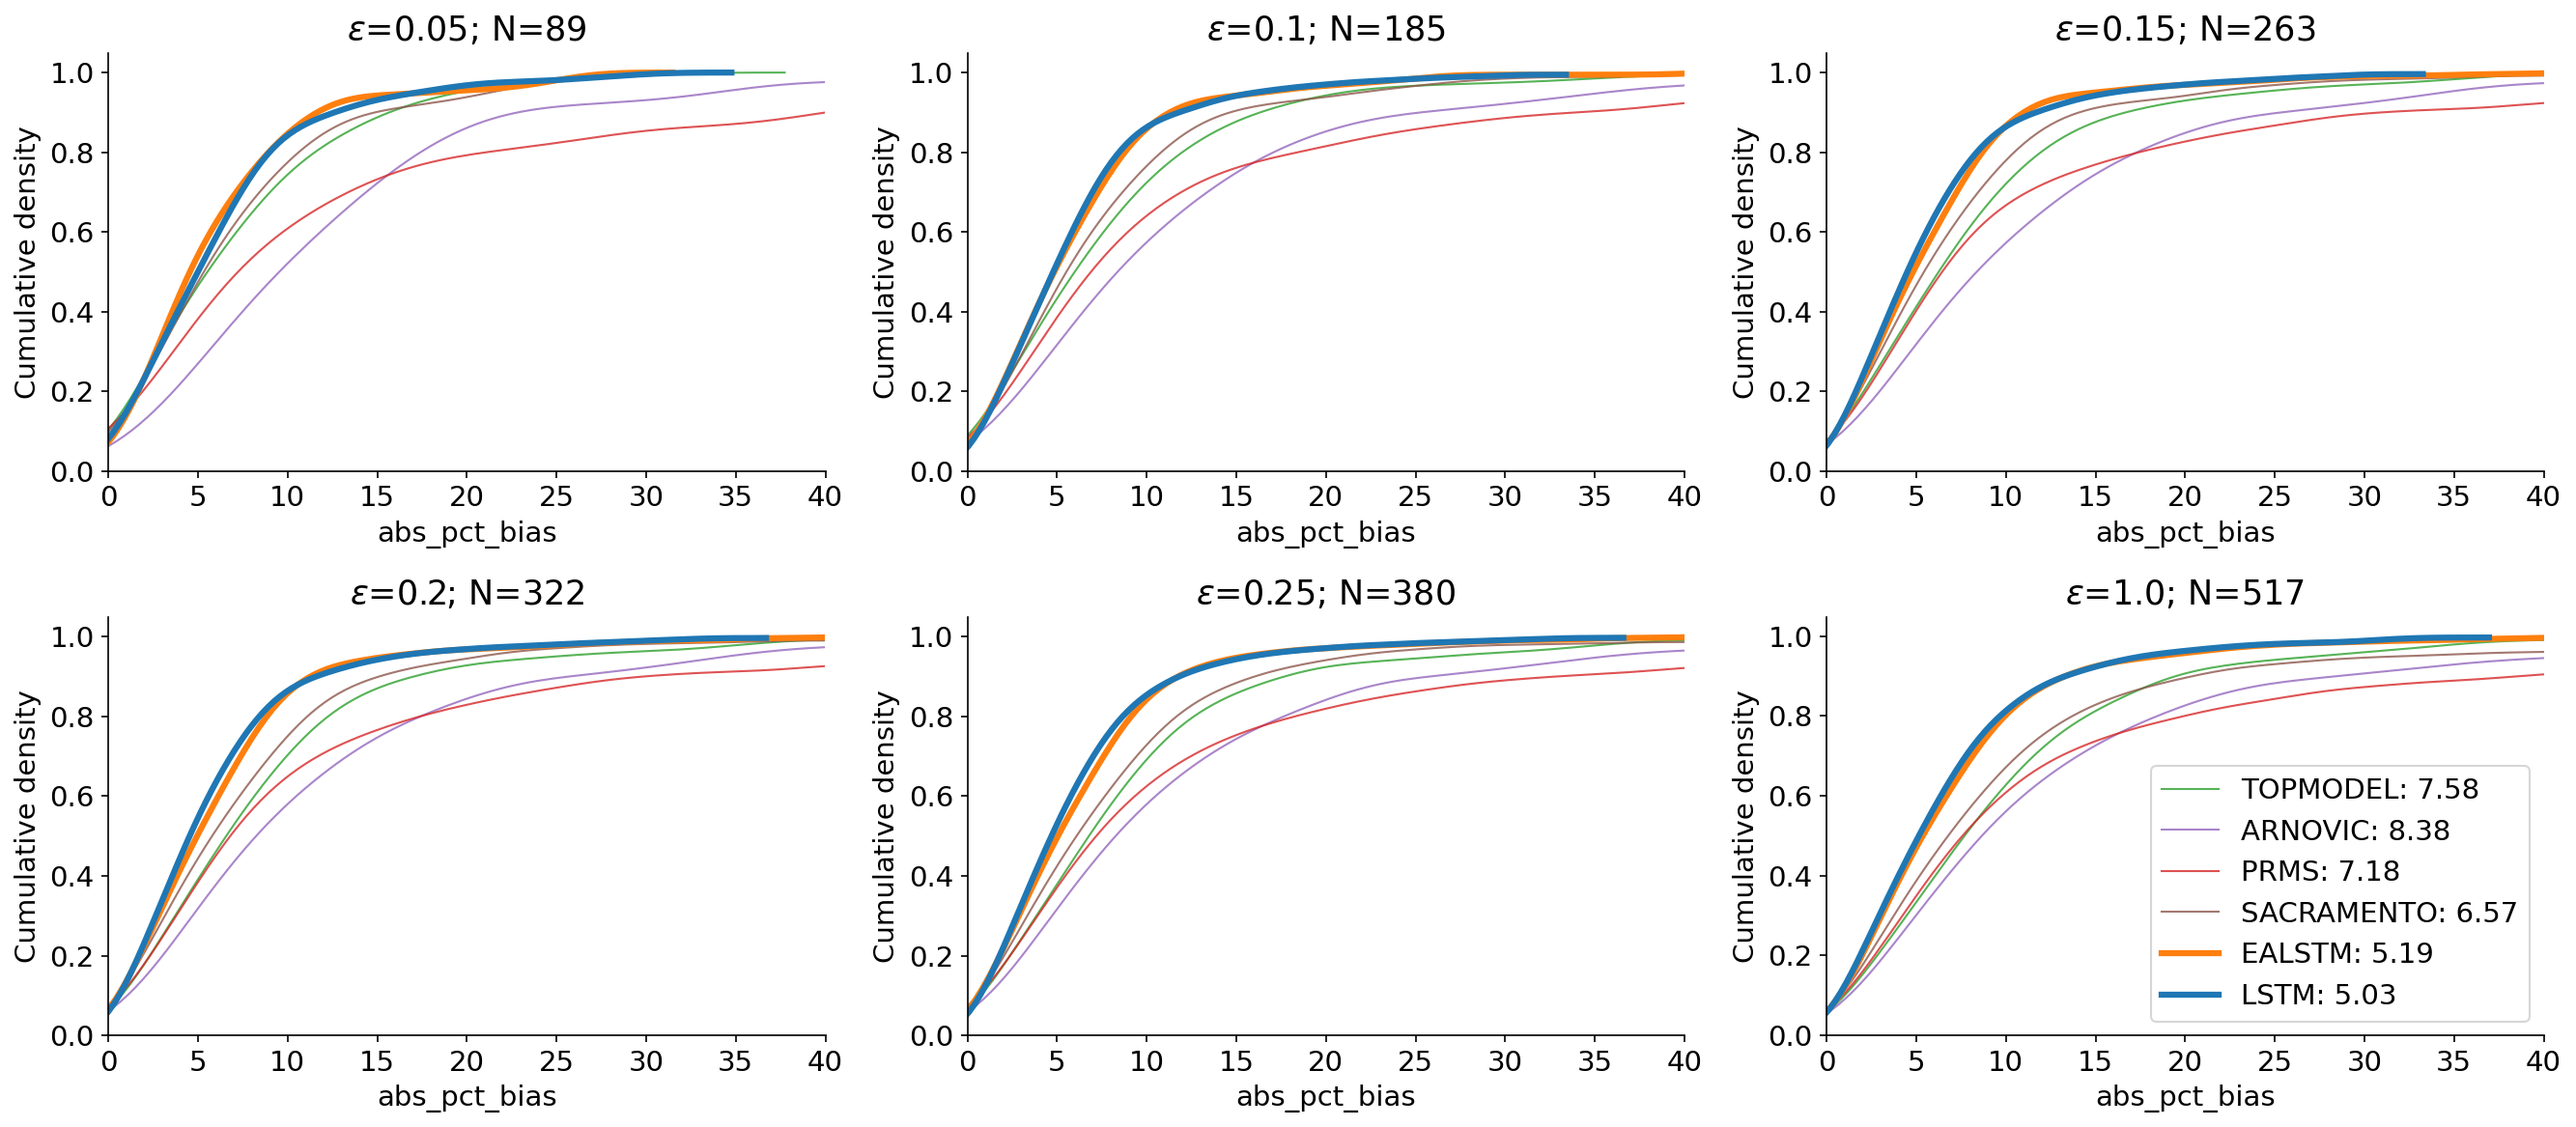

In [22]:
metric = "abs_pct_bias"
clip = (0, 40)
assert metric in all_metrics.keys()

f, axs = plt.subplots(2, 3, figsize=(6*3, 4*2))
thresh = thresholds.threshold.values[0]

for ix, thresh in enumerate(thresholds.threshold.values):
    condition_sids = thresholds.where(thresholds.sel(threshold=thresh)["mask"], drop=True).station_id.values
    ax = axs[np.unravel_index(ix, (2, 3))]
    plot_cdf(all_metrics[metric].loc[np.isin(all_metrics[metric].index, condition_sids)], metric=metric, title="", ax=ax, clip=clip, median=True, show_summary_stat=False);
    ax.set_title(f"$\epsilon$={thresh}; N={len(condition_sids)}")

plt.tight_layout()

In [23]:
all_med = []
for ix, thresh in enumerate(thresholds.threshold.values):
    condition_sids = thresholds.where(thresholds.sel(threshold=thresh)["mask"], drop=True).station_id.values
    
    # create table of median values
    med = all_metrics[metric].loc[np.isin(all_metrics[metric].index, condition_sids)].median()
    med = med.reset_index().rename({0: metric, "index": "Model"}, axis=1)
    med["$\epsilon$"] = thresh
    med = med.set_index(["$\epsilon$", "Model"])
    all_med.append(med) 
    
    
model_order = ['ARNOVIC', 'PRMS', 'SACRAMENTO', 'TOPMODEL', 'EALSTM', 'LSTM', ]
df = pd.concat(all_med).reset_index("Model").pivot_table(index=["$\epsilon$"], values=metric, columns=["Model"]).T.loc[model_order]
df

$\epsilon$,0.05,0.10,0.15,0.20,0.25,1.00
Model,,,,,,
ARNOVIC,9.204473,8.197508,8.129173,8.060349,8.115029,8.382687
PRMS,6.507945,6.678714,6.368727,6.545557,6.740876,7.175999
SACRAMENTO,5.075449,5.348413,5.358343,5.738698,6.006955,6.574838
TOPMODEL,5.357897,5.807790,6.263522,6.551478,6.667872,7.575819
EALSTM,4.282080,4.570128,4.570128,4.825475,4.864332,5.188844
LSTM,4.857339,4.751305,4.372255,4.383723,4.642319,5.033284


In [24]:
print(df.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrr}
\toprule
\$\textbackslash epsilon\$ &  0.05 &  0.10 &  0.15 &  0.20 &  0.25 &  1.00 \\
Model      &       &       &       &       &       &       \\
\midrule
ARNOVIC    &  9.20 &  8.20 &  8.13 &  8.06 &  8.12 &  8.38 \\
PRMS       &  6.51 &  6.68 &  6.37 &  6.55 &  6.74 &  7.18 \\
SACRAMENTO &  5.08 &  5.35 &  5.36 &  5.74 &  6.01 &  6.57 \\
TOPMODEL   &  5.36 &  5.81 &  6.26 &  6.55 &  6.67 &  7.58 \\
EALSTM     &  4.28 &  4.57 &  4.57 &  4.83 &  4.86 &  5.19 \\
LSTM       &  4.86 &  4.75 &  4.37 &  4.38 &  4.64 &  5.03 \\
\bottomrule
\end{tabular}

